In [ ]:
import numpy as np

from keras.preprocessing import image
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.models import Model
from keras.layers import Dropout, Flatten, Dense

from keras.layers import GlobalAveragePooling2D

from keras.optimizers import Adadelta

import matplotlib.pyplot as plt

In [ ]:
#========================================================
#   Simple image plotting routine
#========================================================
def tvscale(img, plot_size=(6,6)):
    plt.rcParams['figure.figsize'] = plot_size
    imgplot = plt.imshow(img,interpolation="none",cmap='gray')
    plt.axis('off')
    plt.show()

In [ ]:
def show_image_row(_imas, plot_size=None):

    if (plot_size != None): plt.rcParams['figure.figsize'] = [plot_size[0], plot_size[1]]

    ncols = len(_imas)
    fig, axes = plt.subplots(nrows=1, ncols=ncols)
    ax = axes.ravel()

    for i in range(ncols):
        ax[i].imshow(_imas[i], cmap='gray',interpolation="none")
        ax[i].axis('off')
        
    plt.tight_layout()
    plt.show()


In [ ]:
X1 = np.load('/content/drive/MyDrive/Cursos/cosmo-late.npy')
X2 = np.load('/content/drive/MyDrive/Cursos/cosmo-early.npy')

X1.shape

(301, 128, 128, 3)

In [ ]:
#--- Concatenate early and late sets. Simple pre-processing
X = np.concatenate((X1,X2), axis=0)

#--- IMPORTANT!!! DO NOT NORMALIZE


#--- Assign classes
Y = np.zeros((X.shape[0]))
Y[0:len(X1)] = 1 #--- Late is 0, early 1
print(Y.shape)


#--- Get random indexes
rand_ind = ( np.arange(0,X.shape[0]) ) 
np.random.shuffle(rand_ind)

#--- Shuffle data
X = X[rand_ind]
Y = Y[rand_ind]


(602,)


In [ ]:
#--- Define training and test datasets

X_train = X[50:].copy()
Y_train = Y[50:].copy()

X_test = X[0:50].copy()
Y_test = Y[0:50].copy()

print(np.min(X_train), np.max(X_train))

0 254


In [ ]:
#--- Load pre-trained VGG16
model = VGG16(weights='imagenet',include_top=False, input_shape=(128,128,3))

#--- Freeze convolutional layers
for layer in model.layers:
  layer.trainable = False

#--- Append new head
#x = model.output 
x = model.get_layer('block4_conv3').output # 2
x = GlobalAveragePooling2D()(x) # 2

x = Flatten()(x)
x = Dense(512, activation='relu', name='dense1')(x)
x = Dense(32, activation='relu', name='dense2')(x)
x = Dropout(0.3)(x)

out = Dense(1, activation='sigmoid', name='out')(x)

model = Model(inputs=model.input, outputs=out)

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()

58900480/58889256 [==============================] - 0s 0us/step
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 128, 128, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 128, 128, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 128, 128, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 64, 64, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 64, 64, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 64, 64, 128)       147584    
______________________________________________________________

In [ ]:
history = model.fit( preprocess_input(X_train), Y_train, batch_size=32, epochs=20, shuffle=True)

Epoch 1/20
18/18 [==============================] - 46s 80ms/step - loss: 3.3811 - accuracy: 0.6235
Epoch 2/20
18/18 [==============================] - 1s 36ms/step - loss: 0.3829 - accuracy: 0.8435
Epoch 3/20
18/18 [==============================] - 1s 35ms/step - loss: 0.2266 - accuracy: 0.8945
Epoch 4/20
18/18 [==============================] - 1s 36ms/step - loss: 0.1956 - accuracy: 0.9149
Epoch 5/20
18/18 [==============================] - 1s 36ms/step - loss: 0.1272 - accuracy: 0.9464
Epoch 6/20
18/18 [==============================] - 1s 36ms/step - loss: 0.0954 - accuracy: 0.9596
Epoch 7/20
18/18 [==============================] - 1s 36ms/step - loss: 0.0816 - accuracy: 0.9820
Epoch 8/20
18/18 [==============================] - 1s 36ms/step - loss: 0.0911 - accuracy: 0.9631
Epoch 9/20
18/18 [==============================] - 1s 36ms/step - loss: 0.1031 - accuracy: 0.9652
Epoch 10/20
18/18 [==============================] - 1s 36ms/step - loss: 0.0451 - accuracy: 0.9941
Epoch 11

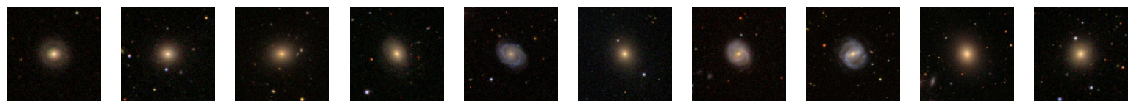

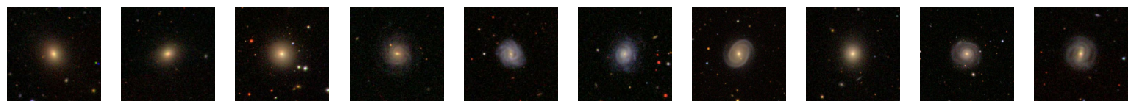

In [ ]:
show_image_row(list(X_test[0:10]), plot_size=[16,1.6])
show_image_row(list(X_test[10:20]), plot_size=[16,1.6])

In [ ]:
def extract_features(_model, _layer, _image):

  #--- For convolutional layers
  #model_out = GlobalAveragePooling2D()(_model.get_layer(_layer).output)

  #--- Dense layers
  model_out = Flatten()(_model.get_layer(_layer).output)

  #--- Not very efficient...
  new_model = Model(inputs=_model.input, outputs=model_out)

  feats = new_model.predict( np.expand_dims(_image, axis=0 ) )

  feats = np.asarray(feats).flatten()

  return feats

In [ ]:
def find_n_closest(x1, x2, n_closest):
  n_samples = x1.shape[0]
  distances = np.zeros(n_samples)

  for i in range(n_samples):
    x_i = x1[i,:]
    diff = x_i-x2
    dista2 = np.sum(diff*diff)
    distances[i] = dista2
  
  distances_sort = np.argsort(distances)
  return distances_sort[0:n_closest]

In [ ]:
#--- Lets compute features for a set of images
features = []
for  im_i in X_test:
  #features.append( extract_features(model, 'block4_conv3', preprocess_input(im_i) ) )
  features.append( extract_features(model, 'dense2',      preprocess_input(im_i) ) )

features = np.asarray(features, dtype=np.float32)

In [ ]:
#--- Choose an image
ind = 4

#--- And some close images
n_closest = 10
closest = find_n_closest(features, features[ind], n_closest)


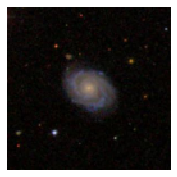

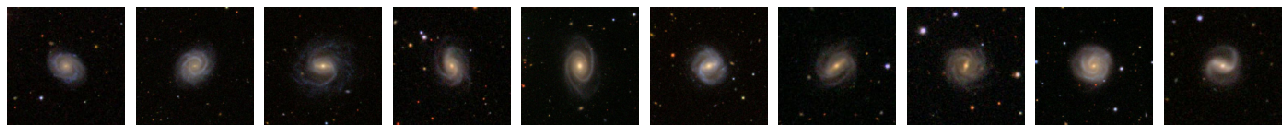

In [ ]:

tvscale(X_test[ind], plot_size=[3,3])
show_image_row(list(X_test[closest]), plot_size=[18,2])
